In [ ]:
## Produce the smearing matrices & efficiencies using the intrinsic nue samples

## Setup

In [12]:
import sys
sys.path.insert(0, 'backend_functions')
from scipy.stats import norm
from matplotlib.colors import LogNorm
import xsec_functions

import importlib
import uproot
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

importlib.reload(xsec_functions)
from xsec_functions import *

import selection_functions
import awkward

import ROOT

from ROOT import TH2D, TH1D, TH1F

import top 
from top import *

In [3]:
importlib.reload(selection_functions)
from selection_functions import *

In [4]:
ISRUN3 = False

In [5]:
intrinsic_pot = parameters(ISRUN3)['intrinsic_pot']
data_pot = parameters(ISRUN3)['beamon_pot']
overlay_pot = parameters(ISRUN3)['overlay_pot']

In [6]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

path = parameters(ISRUN3)['cv_ntuple_path']  # old path '/uboone/data/users/kmistry/work/MCC9/searchingfornues/'

In [7]:
NUE = parameters(ISRUN3)['NUE']
nue = uproot.open("/uboone/data/users/kmistry/work/MCC9/searchingfornues/ntuple_files_v7/neutrinoselection_filt_run1_overlay_intrinsic.root")[fold][tree]
    #uproot.open(path+NUE+".root")[fold][tree]

uproot_nue = nue

## Create pandas dataframes

In [8]:

variables = [
    "selected", "nu_pdg", "shr_theta",
    "trk_score_v", 
    "shr_tkfit_dedx_Y",
    "ccnc", 
    "hits_ratio", "n_tracks_contained", 
    "NeutrinoEnergy2",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
    "nproton", "nu_e", "n_showers_contained", "nu_purity_from_pfp", 
    "shr_score", 
    "trk_energy", "tksh_distance", "tksh_angle",
    "npi0", 
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice",
    "contained_fraction",
    "npion", 
    #"all_trk_energies", "all_trk_hits", "all_shr_energies", "all_shr_hits", ## for secondary shower / track 
    "shrmoliereavg", 
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", 
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", "true_e_visible", "trkshrhitdist2", 
    "weightSplineTimesTune", "weightTune", "swtrig", "true_nu_px", "true_nu_py", "true_nu_pz", 
    "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
    "swtrig_pre", "ppfx_cv", "mc_pdg"]#, 'opening_angle']


In [9]:
nue = nue.pandas.df(variables, flatten=False)

In [ ]:
nue = addAngles(nue)

trk_llr_pid_v = uproot_nue.array('trk_llr_pid_score_v')
trk_id = uproot_nue.array('trk_id')-1 # I think we need this -1 to get the right result
trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])

nue['trkpid'] = trk_llr_pid_v_sel
nue['subcluster'] = nue['shrsubclusters0'] + nue['shrsubclusters1'] + nue['shrsubclusters2']
nue['trkfit'] = nue['shr_tkfit_npointsvalid'] / nue['shr_tkfit_npoints']
    
nue['NeutrinoEnergy2_GeV'] = nue['NeutrinoEnergy2']/1000

nue['is_signal'] = np.where((nue.swtrig_pre == 1) #& (nue.nu_purity_from_pfp>0.5)
                             & (nue.nu_pdg==12) & (nue.ccnc==0) & (nue.nproton>0) & (nue.npion==0) & (nue.npi0==0)
                             & (10 <= nue.true_nu_vtx_x) & (nue.true_nu_vtx_x <= 246)
                             & (-106 <= nue.true_nu_vtx_y) & (nue.true_nu_vtx_y <= 106)
                             & (10 <= nue.true_nu_vtx_z) & (nue.true_nu_vtx_z <= 1026), True, False)

In [ ]:
nue = nue.query('swtrig==1')

## Weights

In [10]:
# cuts applied for bad weights 

nue.loc[ nue['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
nue.loc[ nue['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
nue.loc[ nue['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
nue.loc[ np.isnan(nue['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
nue.loc[ nue['weightTune'] <= 0, 'weightTune' ] = 1.
nue.loc[ nue['weightTune'] == np.inf, 'weightTune' ] = 1.
nue.loc[ nue['weightTune'] > 100, 'weightTune' ] = 1.
nue.loc[ np.isnan(nue['weightTune']) == True, 'weightTune' ] = 1.  
    

In [ ]:
# total weight - combined genie * flux weight (POT scale to intrinsic overlay)
nue['totweight_intrinsic'] = nue['ppfx_cv']*nue['weightSplineTimesTune']
nue['totweight_data'] = nue['ppfx_cv']*nue['weightSplineTimesTune']*(data_pot/intrinsic_pot)
nue['totweight_overlay'] =  nue['ppfx_cv']*nue['weightSplineTimesTune']*(overlay_pot/intrinsic_pot)



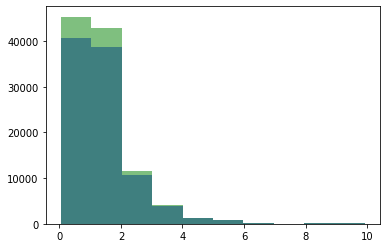

-0.09350346936881382

In [11]:
plt.hist(nue.query('nu_pdg==12')['nu_e'], weights=nue.query('nu_pdg==12')['ppfx_cv'], color='blue', alpha=0.5)
plt.hist(nue.query('nu_pdg==12')['nu_e'], color='green', alpha=0.5)
plt.show()

(sum(nue.query('nu_pdg==12')['ppfx_cv'])-len(nue.query('nu_pdg==12')))/len(nue.query('nu_pdg==12'))

## Apply BDT selection

In [ ]:
# all we care about is signal 

signal_df = nue.query('is_signal==True')

In [ ]:
BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'

BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and trk_energy>0.04' # 40 MeV reco pion/proton cut on leading track 


BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [ ]:
bdt_score_cut = parameters(ISRUN3)['bdt_score_cut']
print("BDT SCORE THRESHOLD = "+str(bdt_score_cut))

In [ ]:
selected_signal_query = signal +' and '+BDT_LOOSE_CUTS+' and BDT_score>'+str(bdt_score_cut)
#print('selected signal query =', selected_signal_query)

In [ ]:
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model(parameters(ISRUN3)['bdt_model'])


In [ ]:

print('Number of generated nue intrinsic events = ' + str(sum(nue.totweight_intrinsic)))
print('Number of generated signal events = ' + str(sum(signal_df.query(signal).totweight_intrinsic)))

training_parameters = parameters(ISRUN3)['bdt_training_parameters']

signal_df = signal_df.query(BDT_LOOSE_CUTS)

# clean datasets 
for column in training_parameters:
    signal_df.loc[(signal_df[column] < -1.0e37) | (signal_df[column] > 1.0e37), column] = np.nan
    
# create testing dmatrix 
signal_test = xgb.DMatrix(data=signal_df[training_parameters])
    
# apply the bdt selection
preds = bdt_model.predict(signal_test)

# add columns for plotting 
signal_df['BDT_score'] = preds

print('Number of selected signal events = ' + str(sum(signal_df.query(selected_signal_query).totweight_intrinsic)))

## Pick a variable! 

In [ ]:
xvar = 'shr_energy_cali'

xvar_dict = xsec_variables(xvar, ISRUN3)

bins = xvar_dict['bins']
true_var = xvar_dict['true_var']
x_label = xvar_dict['x_label']
beamon_pot = xvar_dict['beamon_pot']
xlow = xvar_dict['xlow']
xhigh = xvar_dict['xhigh']

In [ ]:
bincenters = 0.5*(np.array(bins[1:])+np.array(bins[:-1]))

## Reco vs. True Distribution

In [ ]:
###### TRUE ######

bincenters = 0.5*(np.array(bins[1:])+np.array(bins[:-1]))

fig = plt.figure(figsize=(10, 7))

plt.hist(signal_df.query(selected_signal_query)[true_var], bins, 
                weights=signal_df.query(selected_signal_query).totweight_intrinsic, 
                alpha=0.7, label='True', color='orange')


plt.xlabel(x_label, fontsize=15)
plt.ylabel('$\\nu$ / '+str(intrinsic_pot) + ' POT', fontsize=15)
plt.legend(fontsize=15)
plt.ylim(0, 4000)
plt.title('Selected Signal - True Distribution - Intrinsic POT', fontsize=15)
plt.grid()
plt.close()



###### RECO ######

fig = plt.figure(figsize=(10, 7))

plt.hist(signal_df.query(selected_signal_query)[xvar], bins, 
                weights=signal_df.query(selected_signal_query).totweight_intrinsic, 
                alpha=0.4, label='Reco', color='blue')

plt.xlabel(x_label, fontsize=15)
plt.ylabel('$\\nu$  / '+str(intrinsic_pot) + ' POT', fontsize=15)
plt.legend(fontsize=15)
plt.ylim(0, 4000)
plt.title('Selected Signal - Reco Distribution - Intrinsic POT', fontsize=15)
plt.grid()
plt.close()


###### TRUE VS. RECO ######

fig = plt.figure(figsize=(10, 7))

plt.hist(signal_df.query(selected_signal_query)[true_var], bins, 
                weights=signal_df.query(selected_signal_query).totweight_intrinsic, alpha=0.7, 
         label='True', color='orange')

plt.hist(signal_df.query(selected_signal_query)[xvar], bins, 
                weights=signal_df.query(selected_signal_query).totweight_intrinsic, alpha=0.4, 
         label='Reco', color='blue')

plt.xlabel(x_label, fontsize=15)
plt.ylabel('$\\nu$  / '+str(intrinsic_pot) + ' POT', fontsize=15)
plt.legend(fontsize=15)
plt.ylim(0, 4000)
plt.title('Selected Signal - True vs. Reco Distribution - Intrinsic POT', fontsize=15)
plt.grid()
plt.close()

###### TRUE VS. RECO - DATA NORMALIZED ######

fig = plt.figure(figsize=(10, 7))

true_selected = plt.hist(signal_df.query(selected_signal_query)[true_var], bins, 
                weights=signal_df.query(selected_signal_query).totweight_data, alpha=0.7, 
         label='True', color='orange')

reco_selected  = plt.hist(signal_df.query(selected_signal_query)[xvar], bins, 
                weights=signal_df.query(selected_signal_query).totweight_data, alpha=0.4, 
         label='Reco', color='blue')

plt.xlabel(x_label, fontsize=15)
plt.ylabel('$\\nu$  / '+str(data_pot), fontsize=15)
plt.legend(fontsize=15)
plt.title('Selected Signal - True vs. Reco Distribution - DATA POT', fontsize=15)
plt.grid()
plt.show()


In [ ]:
###### TRUE VS. RECO GENERATED - DATA NORMALIZED ######

true_generated = np.array(generated_signal(ISRUN3, true_var, bins, xlow, xhigh))*(data_pot/overlay_pot)
reco_generated = np.array(generated_signal(ISRUN3, xvar, bins, xlow, xhigh))*(data_pot/overlay_pot)

fig = plt.figure(figsize=(10, 7))

plt.hist(bincenters, bins, weights=true_generated, alpha=0.7, label='True', color='orange')
plt.hist(bincenters, bins, weights=reco_generated, alpha=0.4, label='Reco', color='blue')


plt.xlabel(x_label, fontsize=15)
plt.ylabel('$\\nu$  / '+str(data_pot), fontsize=15)
plt.legend(fontsize=15)
plt.title('Generated Signal - True vs. Reco Distribution - DATA POT', fontsize=15)
plt.grid()
plt.show()

## Construct response matrix

In [ ]:
importlib.reload(xsec_functions)
from xsec_functions import *

In [ ]:
smear_dict = smear_matrix(true_var, xvar, bins, ISRUN3, signal_df.query(selected_signal_query),
                          zmax=10, lbl=x_label, save=False, plot=True, eff=True)

In [ ]:
# norm_array[i][j]
# [i][j] == list i, entry j == row i, column j == yval, xval


## Save to unfolding file 

In [ ]:
# generated true signal distribution 

htrue_signal = TH1F("htrue_signal", "Generated MC Signal vs. True "+x_label+" ("+true_var+")", len(bins)-1, np.array(bins))

for i in range(len(bincenters)): 
    htrue_signal.Fill(bincenters[i], true_generated[i])


In [ ]:
# selected reco signal distribution 
hreco = TH1D("hmeas", "Selected MC Signal vs. Reco "+x_label+" ("+xvar+")", len(bins)-1, np.array(bins))

for i in range(len(bincenters)): 
    hreco.Fill(bincenters[i], reco_selected[0][i])

In [ ]:
# response matrix 
r = TH2D("hR", "Response Matrix", len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))

In [ ]:
for i in range(len(bincenters)): # i = column (x)
    for j in range(len(bincenters)): # j = row (y)
    
        w = smear_dict['smear_eff_array'][i][j] # [x][y]
        
        if np.isnan(w): 
            r.Fill(bincenters[i], bincenters[j], 0) 
            
        else: 
            r.Fill(bincenters[i], bincenters[j], w) 
            
        #print('x = '+str(i), 'y = '+str(j), 'counts = '+ str(w))

In [ ]:
f = ROOT.TFile.Open("/uboone/data/users/kmiller/unfolding/WSVD_"+xvar+"_FHCRUN1_MARCH12.root", "UPDATE")

In [ ]:
f.cd()

In [ ]:
htrue_signal.Write()
hreco.Write()
r.Write()

In [ ]:
f.Close()

# EXTRA

In [ ]:
# distribution of selected signal events across opening angle 

fig = plt.figure(figsize=(8, 5))

sel = plt.hist(fhc_sel.query(signal)['opening_angle'], 20, color='orange', range=[-1, 1])

plt.xlabel("cos $\\theta$", fontsize=15)
plt.ylabel("# of selected signal events", fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Signal: PDG==12, CC, N>0 protons, 0 pions, Op.Angle < +/-0.8\nLinear Selection w/o tksh_angle Cut ", fontsize=14)

plt.show()

In [ ]:
# efficiency across opening angle (current linear selection)

eff = [x/y for x, y in zip(sel[0], gen[0])]
eff_err = [ np.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) for i in range(len(eff))]

bincenters = 0.5*(gen[1][1:]+gen[1][:-1])
binwidth = [abs(gen[1][1]-gen[1][0])/2 for x in range(len(bincenters))]

fig = plt.figure(figsize=(8, 5))

plt.errorbar(bincenters, eff, xerr=binwidth, yerr=eff_err, fmt='o', color='seagreen', ecolor='seagreen', markersize=3) 

plt.xlabel("cos $\\theta$", fontsize=15)
plt.ylabel("Efficiency", fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(0, 0.25)

plt.title("Signal: PDG==12, CC, N>0 protons, 0 pions\nLinear Selection with tksh_angle Cut ", fontsize=14)
plt.grid(linestyle=':')
plt.show()



In [ ]:
# efficiency across opening angle (lin sel without tksh_angle cut)


eff = [x/y for x, y in zip(sel[0], gen[0])]
eff_err = [ np.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) for i in range(len(eff))]

bincenters = 0.5*(gen[1][1:]+gen[1][:-1])
binwidth = [abs(gen[1][1]-gen[1][0])/2 for x in range(len(bincenters))]

fig = plt.figure(figsize=(8, 5))

plt.errorbar(bincenters, eff, xerr=binwidth, yerr=eff_err, fmt='o', color='seagreen', ecolor='seagreen', markersize=3) 

plt.xlabel("cos $\\theta$", fontsize=15)
plt.ylabel("Efficiency", fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(0, 0.25)

plt.title("Signal: PDG==12, CC, N>0 protons, 0 pions, \nLinear Selection w/o tksh_angle Cut ", fontsize=14)
plt.grid(linestyle=':')
plt.show()

In [ ]:
# efficiency across opening angle (lin sel without tksh_angle cut & modified signal def )


# efficiency across opening angle (lin sel without tksh_angle cut)


eff = [x/y for x, y in zip(sel[0], gen[0])]
eff_err = [ np.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) for i in range(len(eff))]

bincenters = 0.5*(gen[1][1:]+gen[1][:-1])
binwidth = [abs(gen[1][1]-gen[1][0])/2 for x in range(len(bincenters))]

fig = plt.figure(figsize=(8, 5))

plt.errorbar(bincenters, eff, xerr=binwidth, yerr=eff_err, fmt='o', color='seagreen', ecolor='seagreen', markersize=3) 

plt.xlabel("cos $\\theta$", fontsize=15)
plt.ylabel("Efficiency", fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(-1, 1)
plt.ylim(0, 0.25)

plt.title("Signal: PDG==12, CC, N>0 protons, 0 pions, Op.Angle < +/-0.8\nLinear Selection w/o tksh_angle Cut ", fontsize=14)
plt.grid(linestyle=':')
plt.show()

### Opening Angle

In [ ]:
# compute the magnitude of all MC Particles
def mc_p(df):
    
    p_all = []
    for index, row in df.iterrows():
        p_row = []
        for i in range(len(row['mc_pdg'])): 
            p = math.sqrt( row['mc_px'][i]*row['mc_px'][i] + row['mc_py'][i]*row['mc_py'][i] + row['mc_pz'][i]*row['mc_pz'][i] )
            p_row.append(p)
        
        p_all.append( p_row )
    
    df['mc_p'] = p_all 
    
    return df 


In [ ]:
# now get the proton with the highest momentum 
# use this to construct the truth opening angle 

def tksh_angle_truth(df): 
    
    tksh_angle_truth = []
    for index, row in df.iterrows(): 

        proton_max_p = 0
        proton_max_p_idx = 0
    
        # for each index in the PDG list 
        for i in range(len(row['mc_pdg'])): 
        
            # check if it is a proton 
            if row['mc_pdg'][i]==2212: 
                # check if it is max
                if row['mc_p'][i]>proton_max_p: 
                    # if so, replace
                    proton_max_p = row['mc_p'][i] 
                    proton_max_p_idx = i 
                
        # now use the leading proton index to compute the opening angle 
        proton_p = [ row['mc_px'][i], row['mc_py'][i], row['mc_pz'][i] ]
    
        # and construct electron vector (should be norm'd already)
        elec_p = [ row['elec_px'], row['elec_py'], row['elec_pz'] ]
        elec_p_mag = np.sqrt((elec_p[0]*elec_p[0])+(elec_p[1]*elec_p[1])+(elec_p[2]*elec_p[2]))
    
        # opening angle 
        cos = np.dot(proton_p, elec_p) / (proton_max_p*elec_p_mag)
        if proton_max_p==0 or elec_p_mag==0: 
            tksh_angle_truth.append(np.nan)
        
        else: 
            tksh_angle_truth.append(cos)
            
    df['opening_angle'] = tksh_angle_truth 
    
    return df
 

In [ ]:
fhc_sel = mc_p(fhc_sel)
rhc_sel = mc_p(rhc_sel)

In [ ]:
fhc_sel = tksh_angle_truth(fhc_sel)
rhc_sel = tksh_angle_truth(rhc_sel)

In [ ]:
fhc_sel.query('opening_angle>1')['opening_angle']

In [ ]:
fhc_sel.query('opening_angle<-1')['opening_angle']

In [ ]:
plt.hist([fhc_sel.query(signal)['opening_angle'], fhc_sel.query(signal)['tksh_angle']], 5,
        histtype='step', label=['true', 'reco'], weights=[fhc_sel.query(signal)['totweight_proj'], 
                                                          fhc_sel.query(signal)['totweight_proj']])
plt.title('Opening Angle')
plt.xlabel('cos $\\theta$')
plt.ylabel('$\\nu$ \ 9.23E20 POT')
plt.legend()

#plt.savefig('/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/fhc/opening_angle_wide.pdf', 
#         transparent=True, bbox_inches='tight')
plt.show()



### scattering angle 

In [ ]:
# construct the true scattering angle 

def true_scatangle(df): 
    # length of the neutrino momentum vector
    nu_p_length = np.sqrt((df['true_nu_px']*df['true_nu_px'] + df['true_nu_py']*df['true_nu_py'] + df['true_nu_pz']*df['true_nu_pz']))
    df['true_nu_pmag'] = nu_p_length

    # use the normalized neutrino & electron momentum vectors (both in det coordinates) to construct the angle
    df['true_scatangle'] = ((df['true_nu_px']/df['true_nu_pmag'])*df['elec_px'])+((df['true_nu_py']/df['true_nu_pmag'])*df['elec_py'])+((df['true_nu_pz']/df['true_nu_pmag'])*df['elec_pz'])
   
    return df

In [ ]:
# construct the reco scattering angle 

def reco_scatangle(df): 


    # step 1: construct the neutrino direction vector (interaction vertex - beam target) in detector coordinates
    NuMITargetPos = fromBeamtoDet(0, 0, 0, False)

    # neutrino direction vector - detector coordinates, reconstructed, normalized
    
    nuX = df['reco_nu_vtx_sce_x'] - NuMITargetPos[0]
    nuY = df['reco_nu_vtx_sce_y'] - NuMITargetPos[1]
    nuZ = df['reco_nu_vtx_sce_z'] - NuMITargetPos[2]

    nu_dir_mag = np.sqrt((nuX*nuX)+(nuY*nuY)+(nuZ*nuZ))


    # step 2: normalize the neutrino direction vector and the reco shower momentum vector 
    nuX = nuX/nu_dir_mag
    nuY = nuY/nu_dir_mag
    nuZ = nuZ/nu_dir_mag

    shr_px = df['shr_px']
    shr_py = df['shr_py']
    shr_pz = df['shr_pz']

    shr_p_mag = np.sqrt((shr_px*shr_px)+(shr_py*shr_py)+(shr_pz*shr_pz))

    shr_px = shr_px/shr_p_mag
    shr_py = shr_py/shr_p_mag
    shr_pz = shr_pz/shr_p_mag

    # step 3: take the dot product between them 

    df['reco_scatangle'] = ( (nuX*shr_px)+(nuY*shr_py)+(nuZ*shr_pz) )
    
    return df



In [ ]:
fhc_sel = true_scatangle(fhc_sel)
rhc_sel = true_scatangle(rhc_sel)

In [ ]:
fhc_sel = reco_scatangle(fhc_sel)
rhc_sel = reco_scatangle(rhc_sel)

In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
# angle off the beamline - numi coordinates (degrees)

plt.figure(figsize=(8, 5))

plt.hist([fhc_infv['thbeam'], fhc_infv['phibeam']], 
          40, histtype='step', weights=[fhc_infv['totweight_proj'], fhc_infv['totweight_proj']], 
          label=['$\\theta$ (off beamline)', '$\\phi$ (XY plane)'])
plt.xlabel('Angle [deg]', fontsize=14)
plt.ylabel('$\\nu$ / 9.23E20 POT', fontsize=14)
plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('FHC events in FV (overlay only)', fontsize=14)
plt.legend(fontsize=13)
plt.savefig('/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/fhc/thetavsphi.pdf', 
         transparent=True, bbox_inches='tight')
plt.show()

In [ ]:

plt.figure(figsize=(8, 6))

plt.hist2d(fhc_infv['nu_e'], fhc_infv['thbeam'], 
           40, cmin=0.0000001, range=[[0, 5], [0, 140]], weights=fhc_infv['totweight_proj'])#, norm=LogNorm())
plt.xlabel('true neutrino energy [GeV]', fontsize=14)
plt.ylabel('true angle off beamline [deg]', fontsize=14)
#plt.ylabel('$\\nu$ / 9.23E20 POT', fontsize=14)
#plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar()
#cbar.set_label('$\\nu$ / 11.95E20 POT (RHC projected)', fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.title("FHC events in FV (overlay only)", fontsize=14)
#plt.savefig('/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/rhc/rhc_infv2d.pdf', 
#           transparent=True, bbox_inches='tight')
plt.show()



plt.figure(figsize=(8, 6))

plt.hist2d(fhc_sel['nu_e'], fhc_sel['thbeam'], 
           40, cmin=0.0000001, range=[[0, 5], [0, 140]], weights=fhc_sel['totweight_proj'])
          #, norm=LogNorm())
plt.xlabel('true neutrino energy [GeV]', fontsize=14)
plt.ylabel('true angle off beamline [deg]', fontsize=14)
#plt.ylabel('$\\nu$ / 9.23E20 POT', fontsize=14)
#plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.title("FHC selected events in FV (overlay only)", fontsize=14)
#cbar.set_label('$\\nu$ / 11.95E20 POT (RHC projected)', fontsize=14)
#plt.savefig('/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/rhc/rhc_sel2d.pdf', 
#           transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# distribution of selected signal 

plt.hist(fhc_sel.query(signal)['theta'], 10, range=[0, 3], histtype='step', color='orange')
plt.xlabel('cos($\\theta$)', fontsize=14)
plt.title("angle between incoming & outgoing leptons - what is this?")
plt.show()

In [ ]:
# smearing 1D

plt.hist([fhc_sel.query(signal)['true_scatangle'], fhc_sel.query(signal)['reco_scatangle']], 
         20, histtype='step', weights=[fhc_sel.query(signal)['totweight_proj'], 
                                      fhc_sel.query(signal)['totweight_proj']], 
        label=['true', 'reco'])
plt.xlabel('cos($\\theta$)', fontsize=14)
plt.legend(loc=2)
plt.title("angle between incoming & outgoing leptons")
#plt.savefig('/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/fhc/fhc_scatangle.pdf', 
#           transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# does this assume the neutrino is coming from BNB direction? 

plt.hist([fhc_sel.query(signal)['theta'], fhc_sel.query(signal)['shr_theta']],
         20, range=[0, 3], histtype='step', label=['true', 'reco'])
plt.xlabel('cos($\\theta$)', fontsize=14)
plt.title("angle between incoming & outgoing leptons")
plt.legend()
#plt.savefig('/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/fhc/fhc_theta.pdf', 
#           transparent=True, bbox_inches='tight')
plt.show()

### smearing & binning

In [ ]:
#reco = 'n_tracks_contained'
#true = 'nproton'
#bins = [1, 2, 3, 7]

# total or leading? Uh oh  
#true = 'proton_e'
#reco = 'trk_energy' #trk_energy_tot ?? 
#bins = [ 0.04, 0.24, 0.44, 1.26 ]

#true = 'true_e_visible'
#reco = 'NeutrinoEnergy2'
#bins = [0.19, .4, .61, .82, 1.10, 1.45, 4]

reco = 'shr_energy_cali'
true = 'elec_e'
bins = [0.09, 0.35, 0.65, 1.05, 1.5, 3]



In [ ]:
save = True

In [ ]:
n, b, p = plt.hist([ selected.query(signal)[true], selected.query(nue_CCother)[true]], range=[0, 4],
                        stacked=True, color=['orange', 'limegreen'], label=['signal', 'nue CC other'])
plt.ylim(0, 6000)
plt.legend()
plt.show()

In [ ]:
# from here on out we only work with signal 
selected_signal = selected.query(signal)

In [ ]:
# detector resolution - FHC, RHC, BOTH 

#true_reco_res(true, reco, fhc_sel, 'fhc', 90, save)
#true_reco_res(true, reco, rhc_sel, 'rhc', 90, save)

true_reco_res(true, reco, selected_signal, 'both', 5000, save)

In [ ]:
# min reco selected
min(list(selected.query(signal)[reco]))

In [ ]:
# min true  selected
min(list(selected.query(signal)[true]))

In [ ]:
# smearing - FHC, RHC, BOTH 

#smear_matrix(true, reco, bins, fhc_sel, 'fhc', 55, 'electron energy [GeV]', save)
#smear_matrix(true, reco, bins, rhc_sel, 'rhc', 55, 'electron energy [GeV]', save)

smear_matrix(true, reco, bins, selected_signal, 'both', 2500, 'electron energy [GeV]', save)

In [ ]:
# efficiency - FHC & RHC 

#truth_and_eff(true, bins, fhc_infv, fhc_sel, 'fhc', 100, 'True Electron Energy [GeV]', save)
#truth_and_eff(true, bins, fhc_infv, fhc_sel, 'rhc', 100, 'True Electron Energy [GeV]', save)



In [ ]:
comb_truth_and_eff(true, bins, comb_infv, selected_signal, 'electron energy [GeV]', save)

In [ ]:
print('total events = '+str(sum(selected_signal['totweight_data'])))

### FHC or RHC

In [ ]:
true = 'elec_e'
reco = 'shr_energy_cali'

horn = 'fhc'

if horn=='fhc': 
    gen_df = fhc_infv.query(signal)
    sel_df = fhc_sel.query(signal)
    
elif horn=='rhc': 
    gen_df = rhc_infv.query(signal)
    sel_df = rhc_sel.query(signal)

# shr energy
bins = [0.09, .35, .65, 1.05, 1.5, 3]

# reco neutrino energy 
#bins = [ 0.19, .4, .61, .82, 1.03, 1.4, 2, 4 ]

# track mult
#bins = [1, 2, 3, 7]




In [ ]:
save = True

In [ ]:
true_reco_res(true, reco, sel_df, horn, 90, save)

In [ ]:
truth_and_eff(true, bins, gen_df, sel_df, horn, 100, 'Visible Energy [GeV]', save)

In [ ]:
smear_matrix(true, reco, bins, sel_df, horn, 35, 'neutrino energy [GeV]', save)


In [ ]:
# min reco  selected
min(list(sel_df[reco]))

In [ ]:
# min true  selected
min(list(sel_df[true]))

### FHC & RHC

In [ ]:
comb_sel = pd.concat([fhc_sel, rhc_sel], ignore_index=True)
comb_infv = pd.concat([fhc_infv, rhc_infv], ignore_index=True)

In [ ]:
df_sel = comb_sel.query(signal)
df_gen = comb_infv.query(signal)

In [ ]:
true = 'true_e_visible'
reco = 'NeutrinoEnergy2'


# shr energy
#bins = [0.09, .35, .65, 1.05, 1.5, 3]

# reco energy 
bins = [ 0.19, .4, .61, .82, 1.03, 1.4, 2, 4 ]

# track mult
#bins = [1, 2, 3, 7]

# hadron energy 
#bins = [.04, .23, .42, 1.3]




In [ ]:
save = True

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(df_sel['true_e_visible'], 16, range=[0, 4],histtype='step', label='true visible energy', 
         color='limegreen', weights=df_sel['totweight_proj'])
plt.hist(df_sel['nu_e'], 16, range=[0, 4], histtype='step', label='true $\\nu$ energy', 
         color='blue', weights=df_sel['totweight_proj'])

plt.legend(fontsize=13)
plt.xlabel("True Energy [GeV]", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 175)
plt.ylabel("$\\nu$ / 2.12E21 POT", fontsize=14)
#plt.savefig("/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/both/neutrino_visible_energy.pdf", 
#            transparent=True, bbox_inches='tight') 
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(df_sel['true_e_visible'], 16, range=[0, 4],histtype='step', label='true visible energy', 
         color='limegreen', weights=df_sel['totweight_proj'])
plt.hist(df_sel['NeutrinoEnergy2']/1000, 16, range=[0, 4], histtype='step', 
         label='reco energy', 
         color='red', weights=df_sel['totweight_proj'])

plt.legend(fontsize=13)
plt.xlabel("True Energy [GeV]", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 175)
plt.ylabel("$\\nu$ / 2.12E21 POT", fontsize=14)
#plt.savefig("/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/both/visible_reco_energy.pdf", 
#            transparent=True, bbox_inches='tight') 
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(df_sel['nu_e'], 16, range=[0, 4],histtype='step', label='true $\\nu$ energy', 
         color='blue', weights=df_sel['totweight_proj'])
plt.hist(df_sel['NeutrinoEnergy2']/1000, 16, range=[0, 4], histtype='step', 
         label='reco energy', 
         color='red', weights=df_sel['totweight_proj'])

plt.legend(fontsize=13)
plt.xlabel("True Energy [GeV]", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 175)
plt.ylabel("$\\nu$ / 2.12E21 POT", fontsize=14)
#plt.savefig("/uboone/data/users/kmiller/searchingfornues_v33/v08_00_00_33/plots/both/neutrino_reco_energy.pdf", 
#            transparent=True, bbox_inches='tight') 
plt.show()

In [ ]:
true_reco_res(true, reco, df_sel, 'both', 325, save)

In [ ]:
# normalized to data POT, but made from overlay POT

smear_matrix(true, reco, bins, df_sel, 'both', 350, 'hadronic energy [GeV]', save)